<a href="https://colab.research.google.com/github/firarru/Analisis-Deret-Waktu/blob/main/Tubes_ADW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up Package**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

from scipy.stats import boxcox
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from math import sqrt

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pickle
import warnings
warnings.filterwarnings('ignore')

# **Metadata**

Metadata dari data tersebut meliputi beberapa aspek berikut:

- **Komoditas**:  
   - Kolom berikutnya berisi harga berbagai komoditas, baik energi, logam, maupun pertanian.  
   - Setiap kolom merepresentasikan harga dari suatu komoditas tertentu pada tanggal yang tercantum.  

- **Energi**:  
   - **NATURAL GAS**: Harga gas alam.  
   - **WTI CRUDE**: Harga minyak mentah West Texas Intermediate.  
   - **BRENT CRUDE**: Harga minyak mentah Brent.  
   - **LOW SULPHUR GAS OIL**: Harga minyak gas rendah sulfur.  
   - **ULS DIESEL**: Harga diesel ultra-low sulfur.  
   - **GASOLINE**: Harga bensin.

- **Logam Mulia dan Industri**:  
   - **GOLD**: Harga emas.  
   - **SILVER**: Harga perak.  
   - **COPPER**: Harga tembaga.  
   - **ZINC**: Harga seng.  
   - **NICKEL**: Harga nikel.  

- **Pertanian**:  
   - **SOYBEANS**: Harga kedelai.  
   - **CORN**: Harga jagung.  
   - **WHEAT**: Harga gandum.  
   - **HRW WHEAT**: Harga gandum keras musim dingin.  
   - **SUGAR**: Harga gula.  
   - **COFFEE**: Harga kopi.  
   - **COTTON**: Harga kapas.  

- **Hewan Ternak**:  
   - **LEAN HOGS**: Harga daging babi tanpa lemak.  



# **Load Data**

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/firarru/Analisis-Deret-Waktu/refs/heads/main/Dataset/commodity_futures.csv')
df.head()

,Date,NATURAL GAS,GOLD,WTI CRUDE,BRENT CRUDE,SOYBEANS,CORN,COPPER,SILVER,LOW SULPHUR GAS OIL,...,ZINC,ULS DIESEL,NICKEL,WHEAT,SUGAR,GASOLINE,COFFEE,LEAN HOGS,HRW WHEAT,COTTON
0,2000-01-03,NaN,NaN,NaN,NaN,456.50,200.75,NaN,NaN,NaN,...,1237.50,NaN,8446.0,247.50,6.10,NaN,116.50,55.975,274.25,51.07
1,2000-01-04,2.176,283.7,25.55,24.39,464.25,203.00,0.8480,5.375,213.50,...,1215.00,67.78,8314.0,247.25,5.77,NaN,116.25,55.625,274.00,50.73
2,2000-01-05,2.168,282.1,24.91,23.73,469.25,203.00,0.8565,5.210,213.00,...,1209.25,66.55,8307.0,249.75,5.81,NaN,118.60,55.075,276.25,51.56
3,2000-01-06,2.196,282.4,24.78,23.62,468.00,203.75,0.8530,5.167,211.25,...,1212.00,66.28,8252.0,248.50,5.77,NaN,116.85,55.175,275.00,52.08
4,2000-01-07,2.173,282.9,24.22,23.09,471.50,207.00,0.8540,5.195,205.25,...,1209.25,64.75,8174.0,251.75,5.84,NaN,114.15,55.625,277.75,53.96


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6092 entries, 0 to 6091
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 6092 non-null   object 
 1   NATURAL GAS          6083 non-null   float64
 2   GOLD                 6082 non-null   float64
 3   WTI CRUDE            6083 non-null   float64
 4   BRENT CRUDE          6090 non-null   float64
 5   SOYBEANS             6083 non-null   float64
 6   CORN                 6084 non-null   float64
 7   COPPER               6083 non-null   float64
 8   SILVER               6079 non-null   float64
 9   LOW SULPHUR GAS OIL  6090 non-null   float64
 10  LIVE CATTLE          6084 non-null   float64
 11  SOYBEAN OIL          6079 non-null   float64
 12  ALUMINIUM            6045 non-null   float64
 13  SOYBEAN MEAL         6082 non-null   float64
 14  ZINC                 6046 non-null   float64
 15  ULS DIESEL           6083 non-null   f

# **Preprocessing**

In [ ]:
# Memilih kolom 'Date' dan 'KOPI' saja
df1= df.loc[:, ["Date", "COFFEE"]]
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6092 entries, 0 to 6091
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6092 non-null   object 
 1   COFFEE  6080 non-null   float64
dtypes: float64(1), object(1)
memory usage: 95.3+ KB


In [ ]:
# Cek persentase nilai null di kolom 'COFFEE'
total_null = df1['COFFEE'].isnull().sum()
total_rows = len(df1)
percentage_null = (total_null / total_rows) * 100

print(f"Total missing values in 'COFFEE': {total_null}")
print(f"Percentage of missing values in 'COFFEE': {percentage_null:.2f}%")

Total missing values in 'COFFEE': 12
Percentage of missing values in 'COFFEE': 0.20%


Karena data merupakan time series, pada kasus ini null value akan diisi dengan mean

In [ ]:
df1 = df1.fillna(df1['COFFEE'].mean())
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6092 entries, 0 to 6091
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6092 non-null   object 
 1   COFFEE  6092 non-null   float64
dtypes: float64(1), object(1)
memory usage: 95.3+ KB


Data deret waktu yang dipakai selama periode 1 tahun pada 2020

In [ ]:
df1 = df1[(df1['Date'] >= '2020-01-01') & (df1['Date'] <= '2020-12-31')].reset_index(drop=True)
df1.shape

(259, 2)

Kemudian data waktu diubah tipe datanya dari object menjadi datetime dan dibuat sebagai index untuk mempermudah dalam pengolahan data

In [ ]:
df1.set_index(pd.to_datetime(df1['Date']), inplace=True)
df1.drop('Date', axis=1, inplace=True)
df1.head()

,COFFEE
Date,
2020-01-02,127.10
2020-01-03,126.35
2020-01-06,122.15
2020-01-07,122.40
2020-01-08,119.15


# **Plot Data**

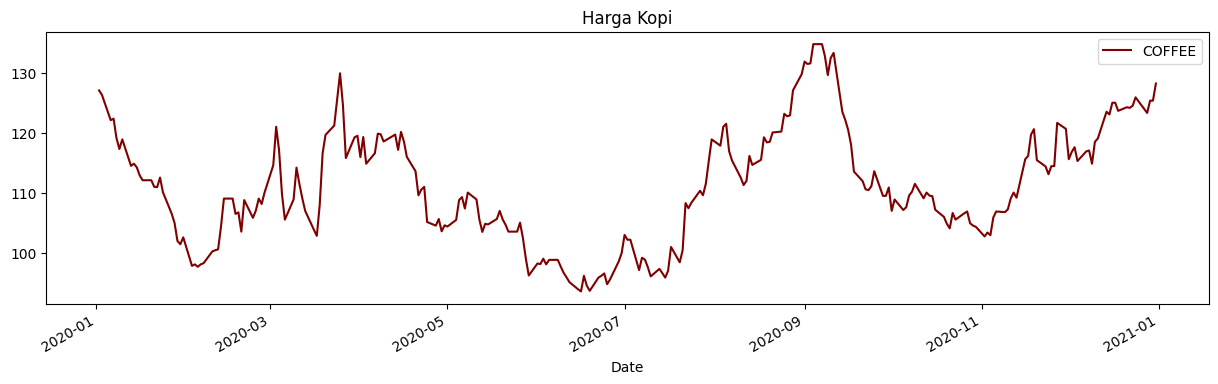

In [ ]:
df1.plot(color='maroon', figsize=(15,4))
plt.title('Harga Kopi')
plt.savefig('Harga Kopi.png')
plt.show()

Berdasarkan grafik, data harga komoditas kopi tidak stasioner dan juga tidak memiliki pola atau tren tertentu. Adanya fluktuasi atau variasi pergerakan harga kopi yang tidak konstan sepanjang waktu menunjukkan bahwa variansi data tidak stasioner.

Kondisi ini juga disebut sebagai heteroskedastisitas yang berarti adanya volatilitas yang tidak stabil sepanjang waktu

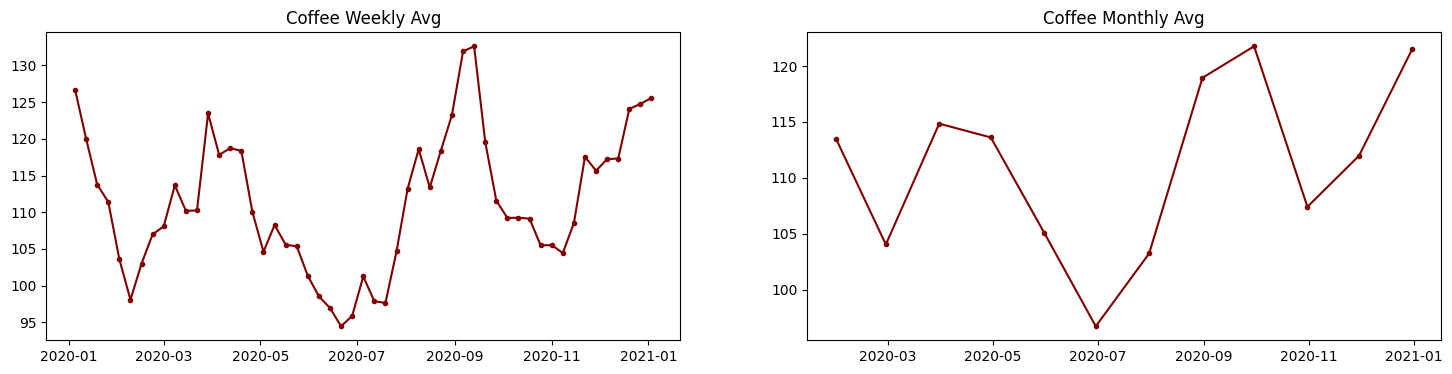

In [ ]:
df1_weekly_avg = df1.resample('W').mean()
df1_monthly_avg = df1.resample('M').mean()

plt.figure(figsize=(18,4))
plt.subplot(121)
plt.title('Coffee Weekly Avg')
plt.plot(df1_weekly_avg, "-o", markersize=3, color='maroon')
plt.subplot(122)
plt.title('Coffee Monthly Avg')
plt.plot(df1_monthly_avg, "-o", markersize=3, color='maroon')

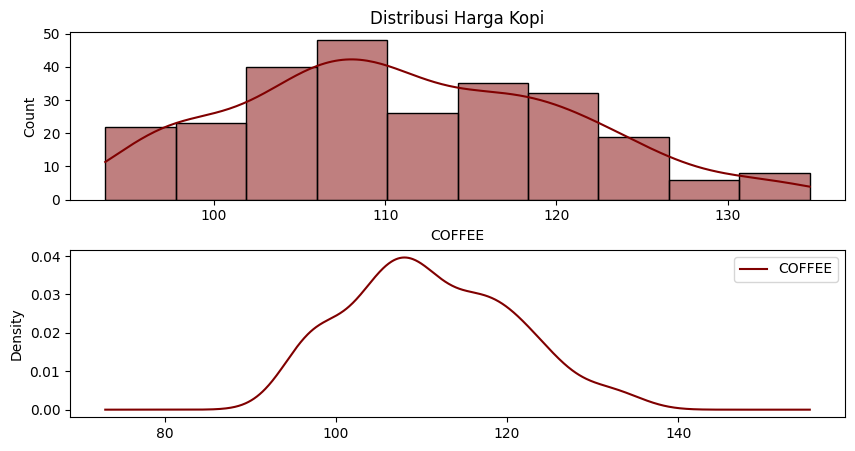

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(10,5))
sns.histplot(df1['COFFEE'], kde=True, color='maroon', ax=ax1)
ax1.set_title('Distribusi Harga Kopi')
df1.plot(kind='kde', ax=ax2, color='maroon')
plt.subplots_adjust(hspace=0.3)
plt.show()

Berdasarkan grafik tersebut, harga komoditas kopi selama periode 2020 berdistribusi normal

# **Stasioneritas Data Terhadap Variansi dan Transformasi Menggunakan Box Cox**

Berdasarkan penjelasan dari grafik sebelumnya, bahwa data yang dimiliki tidak stasioner secara varians, maka perlu dilakukan transformasi data agar data stasioner secara varians

Karena 𝜆(lambda) adalah parameter transformasi. Maka hal pertama yang harus dilakukan adalah melihat berapa 𝜆 optimal yang diduga. 𝜆 yang optimal dapat diduga dengan metode maksimum Likelihood. Nilai optimal adalah nilai yang menghasilkan perkiraan terbaik terhadap kurva distribusi normal


In [16]:
df1_boxcox, best_lambda = boxcox(df1['COFFEE'])
print('Nilai 𝜆(lambda) optimal', best_lambda)

Nilai 𝜆(lambda) optimal -0.5655535458560442


Karena 𝜆 yang dihasilkan adalah -0.57 atau -0.5 maka rumus transformasi yang dipakai adalah 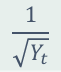

Text(0.5, 1.0, 'Distribusi Transformasi Harga Kopi')

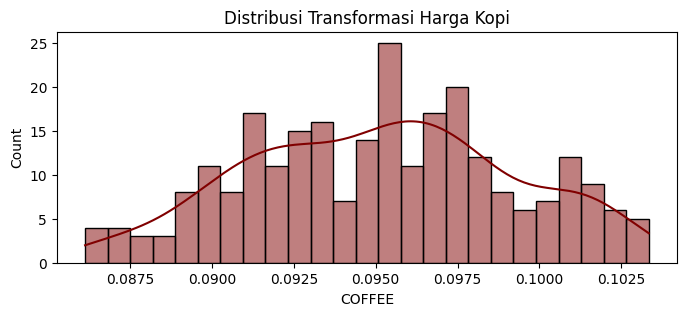

In [32]:
#perform Box-Cox transformation on original data
df1_transform_boxcox = 1/np.sqrt(df1['COFFEE'])

plt.figure(figsize=(8, 3))
sns.histplot(df1_transform_boxcox, kde=True, color='maroon', bins=25)
plt.title('Distribusi Transformasi Harga Kopi')

In [33]:
print('Batas bawah = ', df1_transform_boxcox.min())
print('Batas atas = ', df1_transform_boxcox.max())

Batas bawah =  0.08613012031869431
Batas atas =  0.10333468243382735


Hasil transformasi dari 𝜆 = -0.5 berada pada interval 0.086 sampai 0.103. Dimana lambda value (-0.5) disebut rounded value.


Nilai 0.086 adalah batas bawah dan 0.103 adalah batas atas. Karena nilai rounded value berada di luar interval transformasi, maka dapat disimpulkan bahwa data tidak stasioner terhadap variansi

# **Stasioneritas Data Terhadap Mean Menggunakan Uji ADF**

In [38]:
def test_stationarity(timeseries):
  result = adfuller(timeseries)
  print('ADF Statistic: ', result[0])
  print('p-value: ', result[1])
  print('Critical Values: ')
  for key, value in result[4].items():
    print('\t', key, ':', value)

  if result[1] <= 0.05:
    print('Kesimpulan : Data adalah stasioner.')
  else:
    print('Kesimpulan : Data tidak stasioner.')

In [39]:
# Uji stasionaritas pada data setelah transformasi
print("Uji stasionaritas sebelum transformasi:")
test_stationarity(df1)

print("\nUji stasionaritas setelah transformasi Box-Cox:")
test_stationarity(df1_transform_boxcox)

Uji stasionaritas sebelum transformasi:
ADF Statistic:  -2.3433391215759736
p-value:  0.15837082842733952
Critical Values: 
	 1% : -3.4562572510874396
	 5% : -2.8729420379793598
	 10% : -2.5728461399461744
Kesimpulan : Data tidak stasioner.

Uji stasionaritas setelah transformasi Box-Cox:
ADF Statistic:  -2.34275056373604
p-value:  0.15855039117812597
Critical Values: 
	 1% : -3.4560535712549925
	 5% : -2.8728527662442334
	 10% : -2.5727985212493754
Kesimpulan : Data tidak stasioner.


Sebelum dilakukan trasnformasi, data tidak stasioner secara rataan. Namun setelah dilakukan transformasi menggunakan Box-Cox, data masih tidak stasioner secara rataan. Dikarenakan data masih tidak stasioner, maka perlu dilakukan differencing

# **Differencing Pertama**


## **Differencing Non Seasonal**

In [63]:
df1_diff = df1.diff().dropna()
print("Uji stasionaritas setelah differencing pertama:")
test_stationarity(df1_diff['COFFEE'])

Uji stasionaritas setelah differencing pertama:
ADF Statistic:  -11.712800125521367
p-value:  1.4751911608214284e-21
Critical Values: 
	 1% : -3.4561550092339512
	 5% : -2.8728972266578676
	 10% : -2.5728222369384763
Kesimpulan : Data adalah stasioner.


df1.diff() : Code tersebut merupakan differencing non seasonal.

Jika ingin melakukan differencing secara seasonal, maka perlu didefinisikan ke dalam diff() berapa periode seasonal yang dipakai

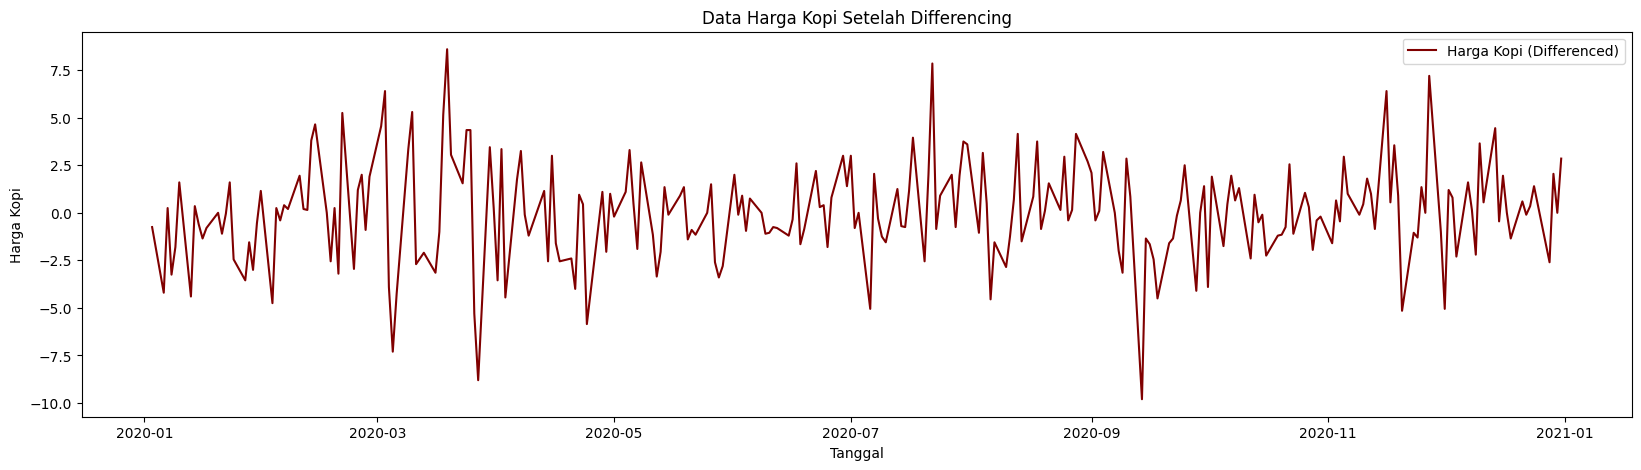

In [64]:
# Visualisasi data setelah differencing
plt.figure(figsize=(20,5))
plt.plot(df1_diff, label='Harga Kopi (Differenced)', color='maroon')
plt.title('Data Harga Kopi Setelah Differencing')
plt.xlabel('Tanggal')
plt.ylabel('Harga Kopi')
plt.legend()
plt.show()

Berdasarkan uji ADF setelah dilakukan differencing, menunjukkan bahwa data sudah stasioner secara rataan, begitu juga berdasarkan grafik terlihat bahwa data sudah stasioner

Setelah data sudah stasioner, kita identifikasi model yang dimiliki data ini

### Plot ACF dan PACF

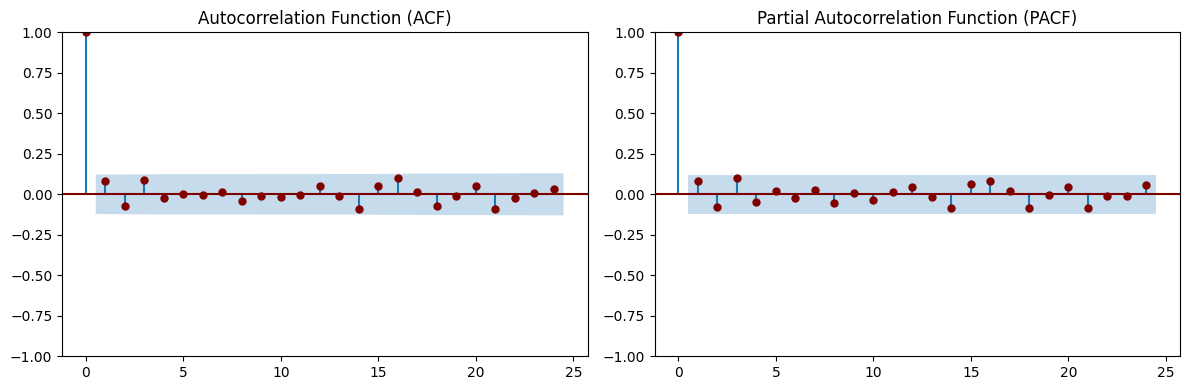

In [65]:
import statsmodels.api as sm

# Create subplots
significance_level = 0.05
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF plot with significant lines
sm.graphics.tsa.plot_acf(df1_diff, lags=24, alpha=significance_level,ax=ax1, color='maroon')
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot with significant lines
sm.graphics.tsa.plot_pacf(df1_diff, lags=24, alpha=significance_level,ax=ax2, color='maroon')
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


Berdasarkan plot Korelogram ACF -> cut off pada lag 1, 2, 3, 14, 16, 18, 21

Berdasarkan plot Korelogram PACF -> cut off pada lag 1, 2, 3, 14, 16, 18, 21

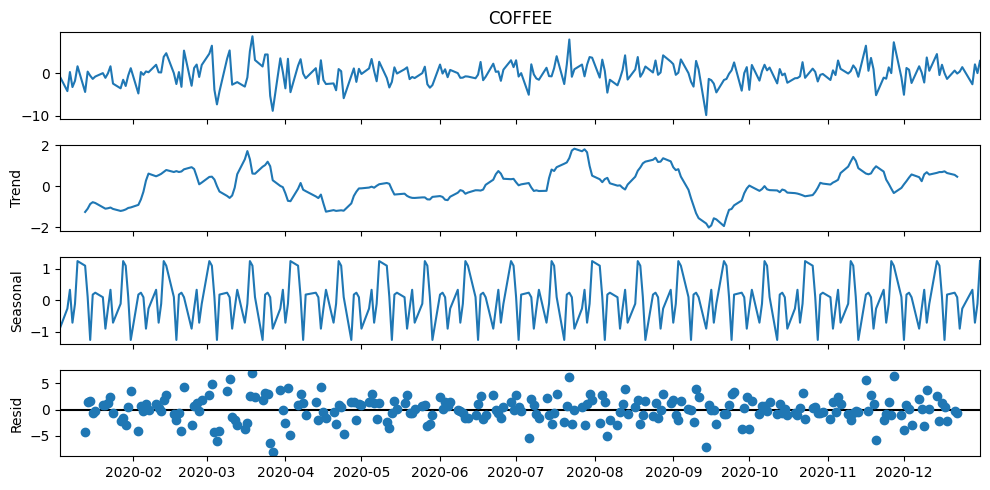

In [66]:
plt.rcParams['figure.figsize'] = 10, 5
decomposition = seasonal_decompose(df1_diff['COFFEE'], period = 12, model = 'additive')
decomposition.plot()
# plt.savefig('Trend, Seasonal, Residual Graph.png')
plt.show()

### Identifikasi Model

In [55]:
# pip install pmdarima

In [67]:
# Lakukan instalasi di atas jika terjadi eror
from pmdarima import auto_arima
model = auto_arima(df1_diff['COFFEE'], d=1, D=0, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1383.541, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1336.818, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1381.546, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1289.897, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1283.109, Time=0.37 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1272.897, Time=2.54 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1270.138, Time=1.78 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.22 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1268.179, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1270.934, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.34 s

In [68]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  258
Model:               SARIMAX(5, 1, 0)   Log Likelihood                -628.090
Date:                Wed, 18 Dec 2024   AIC                           1268.179
Time:                        16:37:52   BIC                           1289.474
Sample:                             0   HQIC                          1276.743
                                - 258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7345      0.051    -14.518      0.000      -0.834      -0.635
ar.L2         -0.6835      0.064    -10.645      0.000      -0.809      -0.558
ar.L3         -0.4137      0.080     -5.160      0.000      -0.571      -0.257
ar.L4         -0.3108      0.068     -4.542      0.000      -0.445      -0.177
ar.L5         -0.1360      0.057     -2.370      0.018      -0.248      -0.024
sigma2         7.7388      0.605     12.797      0.000       6.554       8.924
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                34.76
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.35
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Uji Kelayakan dengan Ljung Box

H0 : Residual data adalah white noise

H1 : Residual data bukan white noise


Nilai Q = 0.16 &
Chi Square = 0.69

Aturan : Tolak H0 jika Nilai Q < Chi Square

Keputusan : Tolak H0, sehingga residual data bukan white noise

Karena residual data bukan white noise, maka dilakukan differencing secara seasonal

## **Differencing Seasonal**

Differencing pertama pada seasonal dilakukan dengan periode seasonal = 12

In [73]:
df1_diffs = df1_diff.diff(12).dropna()
test_stationarity(df1_diffs['COFFEE'])

ADF Statistic:  -7.915604273344815
p-value:  3.843713281644089e-12
Critical Values: 
	 1% : -3.4586084859607156
	 5% : -2.873972159235721
	 10% : -2.57339565928848
Kesimpulan : Data adalah stasioner.


### Identifikasi Model Kedua

In [70]:
model2 = auto_arima(df1_diffs['COFFEE'], d=1, D=1, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=3.57 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1659.166, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1485.043, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1615.212, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1428.429, Time=0.58 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.71 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.48 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1469.624, Time=0.45 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1395.022, Time=0.88 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1443.134, Time=0.38 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.45 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.79 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1391.458, Time=0.88 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=1439.1

In [72]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  246
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -679.126
Date:                            Wed, 18 Dec 2024   AIC                           1374.252
Time:                                    16:42:33   BIC                           1401.860
Sample:                                         0   HQIC                          1385.385
                                            - 246                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7016      0.060    -11.674      0.000      -0.819      -0.584
ar.L2         -0.6331      0.083     -7.612      0.000      -0.796      -0.470
ar.L3         -0.4093      0.092     -4.467      0.000      -0.589      -0.230
ar.L4         -0.3590      0.075     -4.813      0.000      -0.505      -0.213
ar.L5         -0.1951      0.063     -3.100      0.002      -0.319      -0.072
ar.S.L12      -1.0072      0.061    -16.437      0.000      -1.127      -0.887
ar.S.L24      -0.4461      0.066     -6.773      0.000      -0.575      -0.317
sigma2        18.7524      1.433     13.083      0.000      15.943      21.562
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                28.37
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.18
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Uji Kelayakan dengan Ljung Box

H0 : Residual data adalah white noise

H1 : Residual data bukan white noise


Nilai Q = 0.09 || Chi Square = 0.77

Aturan : Tolak H0 jika Nilai Q < Chi Square

Keputusan : Tolak H0, sehingga residual data bukan white noise

Karena residual data bukan white noise, maka dilakukan differencing yang kedua

# **Differencing Kedua**

## **Differencing Non Seasonal Kedua**

In [74]:
df1_diff2 = df1_diffs.diff().dropna()
test_stationarity(df1_diff2['COFFEE'])

ADF Statistic:  -7.223632278194846
p-value:  2.0801806911249115e-10
Critical Values: 
	 1% : -3.4592326027153493
	 5% : -2.8742454699025872
	 10% : -2.5735414688888465
Kesimpulan : Data adalah stasioner.


### Identifikasi Model

In [77]:
model3 = auto_arima(df1_diff2['COFFEE'], d=2, D=1, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,1,1)[12]             : AIC=inf, Time=12.87 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=2157.084, Time=0.07 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=1880.727, Time=1.02 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=2.85 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=2006.900, Time=0.15 sec
 ARIMA(1,2,0)(2,1,0)[12]             : AIC=1821.592, Time=0.75 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=inf, Time=3.98 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=inf, Time=1.49 sec
 ARIMA(0,2,0)(2,1,0)[12]             : AIC=1965.759, Time=0.40 sec
 ARIMA(2,2,0)(2,1,0)[12]             : AIC=1701.245, Time=0.72 sec
 ARIMA(2,2,0)(1,1,0)[12]             : AIC=1756.830, Time=0.31 sec
 ARIMA(2,2,0)(2,1,1)[12]             : AIC=inf, Time=9.90 sec
 ARIMA(2,2,0)(1,1,1)[12]             : AIC=inf, Time=2.36 sec
 ARIMA(3,2,0)(2,1,0)[12]             : AIC=1646.971, Time=1.03 sec
 ARIMA(3,2,0)(1,1,0)[12]             : AIC=1696.

In [78]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  245
Model:             SARIMAX(5, 2, 0)x(2, 1, 0, 12)   Log Likelihood                -782.061
Date:                            Wed, 18 Dec 2024   AIC                           1580.122
Time:                                    16:55:52   BIC                           1607.662
Sample:                                         0   HQIC                          1591.230
                                            - 245                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7424      0.053    -33.161      0.000      -1.845      -1.639
ar.L2         -1.9872      0.102    -19.434      0.000      -2.188      -1.787
ar.L3         -1.6162      0.119    -13.583      0.000      -1.849      -1.383
ar.L4         -0.9872      0.102     -9.725      0.000      -1.186      -0.788
ar.L5         -0.3849      0.063     -6.130      0.000      -0.508      -0.262
ar.S.L12      -1.0259      0.051    -20.058      0.000      -1.126      -0.926
ar.S.L24      -0.4932      0.064     -7.661      0.000      -0.619      -0.367
sigma2        47.2164      3.773     12.514      0.000      39.821      54.611
===================================================================================
Ljung-Box (L1) (Q):                   4.93   Jarque-Bera (JB):                11.65
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Uji Kelayakan dengan Ljung Box

H0 : Residual data adalah white noise

H1 : Residual data bukan white noise

Nilai Q = 4.93 || Chi Square = 0.037

Aturan : Tolak H0 jika Nilai Q < Chi Square

Keputusan : Gagal tolak H0, sehingga residual data adalah white noise

# **Estimasi Parameter**

Sehingga diperoleh model SARIMA(5,2,0)(2,1,0)[12]

Selanjutnya kita lakukan estimasi parameter orde

In [87]:
# Estimasi parameter menggunakan metode MLE dengan SARIMA
model3 = sm.tsa.statespace.SARIMAX(df1_diff2['COFFEE'], order=(5, 2, 0), seasonal_order=(2, 1, 0, 12))
results = model.fit()  # Default: Metode Maximum Likelihood

# Menampilkan hasil estimasi
print(results.summary())

# Ekstrak parameter
print("Parameter AR1:", results.params['ar.L1'])
print("Parameter AR2:", results.params['ar.L2'])
print("Parameter AR3:", results.params['ar.L3'])
print("Parameter AR4:", results.params['ar.L4'])
print("Parameter AR5:", results.params['ar.L5'])
print("Parameter SAR12:", results.params['ar.S.L12'])
print("Parameter SAR24:", results.params['ar.S.L24'])
print("Varians Residual (sigma2):", results.params['sigma2'])


                                     SARIMAX Results                                      
Dep. Variable:                             COFFEE   No. Observations:                  245
Model:             SARIMAX(5, 2, 0)x(2, 1, 0, 12)   Log Likelihood                -782.061
Date:                            Wed, 18 Dec 2024   AIC                           1580.122
Time:                                    17:06:12   BIC                           1607.662
Sample:                                         0   HQIC                          1591.230
                                            - 245                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7424      0.053    -33.161      0.000      -1.845      -1.639
ar.L2         -1.9872      0.102   

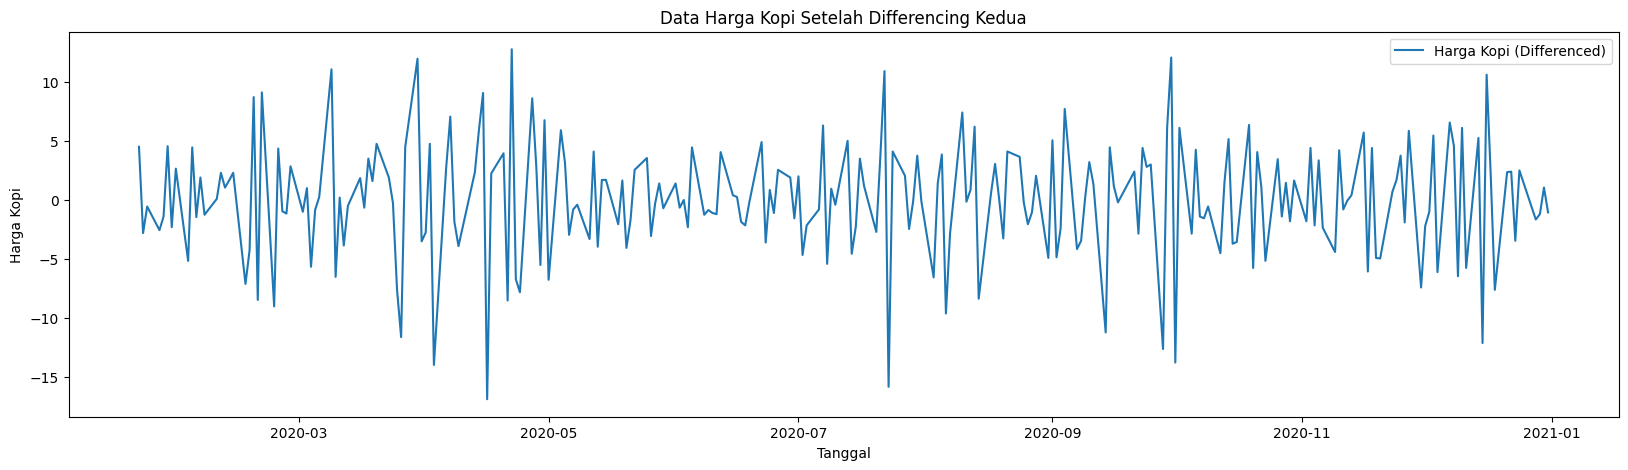

In [81]:
# Visualisasi data setelah differencing
plt.figure(figsize=(20,5))
plt.plot(df1_diff2, label='Harga Kopi (Differenced)')
plt.title('Data Harga Kopi Setelah Differencing Kedua')
plt.xlabel('Tanggal')
plt.ylabel('Harga Kopi')
plt.legend()
plt.show()

# **Uji Kenormalan sisaan dengan menggunakan Kolmogorof-Smirnov atau Shapiro-Wilks**

In [84]:
from scipy import stats
# Uji Kolmogorov-Smirnov
statistic, p_value = stats.kstest(df1_diff2, 'norm', args=(df1_diff2['COFFEE'].mean(), df1_diff2['COFFEE'].std()))

# Output hasil uji
print(f"Statistik K-S: {statistic}")
print(f"P-Value: {p_value}")

# Kesimpulan
if p_value < 0.05:
    print("Tolak H0: Data tidak berdistribusi normal.")
else:
    print("Gagal tolak H0: Data berdistribusi normal.")

Statistik K-S: [0.05195617]
P-Value: [0.50617645]
Gagal tolak H0: Data berdistribusi normal.


# **Forecasting**

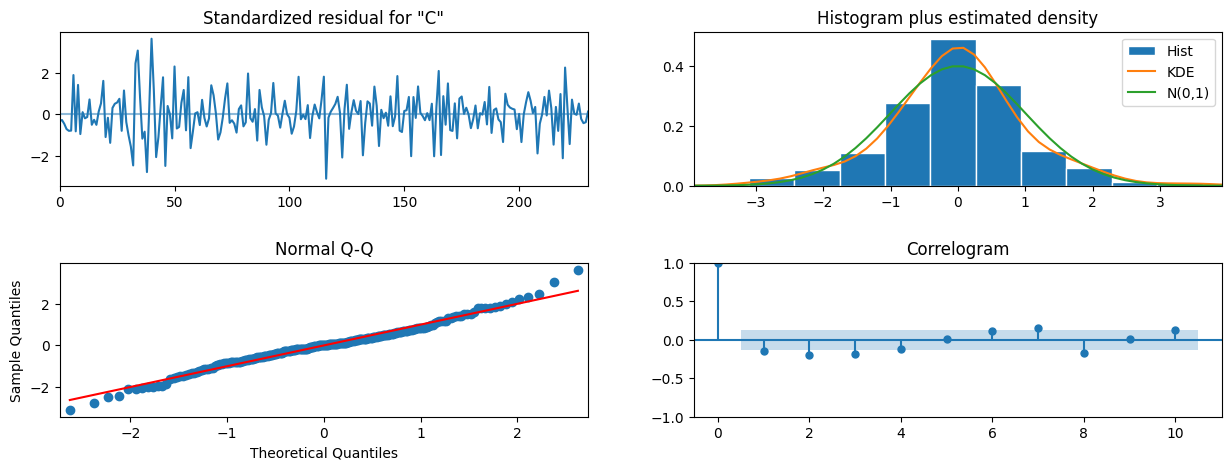

In [94]:
results.plot_diagnostics(figsize = (15,5))
plt.subplots_adjust(hspace = 0.5)
# plt.savefig('Diagnostic Plot of Best Model')
plt.show()

# **Evaluasi Metrik**

# **Data Gula**

In [ ]:
df2 = df.loc[:, ["Date", "SUGAR"]]
df2.info()

In [ ]:
df2.plot(kind='hist', bins=30, color='maroon')

In [ ]:
df2 = df2.fillna(df2['SUGAR'].mean())
df2.info()

In [ ]:
df2.plot(kind='hist', bins=30, color='maroon')

In [ ]:
df2 = df2[(df2['Date'] >= '2017-01-01') & (df2['Date'] <= '2021-12-31')].reset_index(drop=True)
df2

In [ ]:
df2.set_index(pd.to_datetime(df2['Date']), inplace=True)
df2.drop('Date', axis=1, inplace=True)
df2.head()

In [ ]:
df2.plot(color='maroon')
plt.title('Harga Gula')
plt.savefig('Harga Gula.png')
plt.show()

In [ ]:
df2_weekly_avg = df2.resample('W').mean()
df2_monthly_avg = df2.resample('M').mean()

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title('Sugar Weekly Avg')
plt.plot(df2_weekly_avg, "-o", markersize=3, color='maroon')
plt.subplot(122)
plt.title('Sugar Monthly Avg')
plt.plot(df2_monthly_avg, "-o", markersize=3, color='maroon')

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(10,5))
df2.hist(ax=ax1, bins=20, color='maroon')
df2.plot(kind='kde', ax=ax2, color='maroon')
plt.title('Distribusi Harga Gula')
plt.show()